In [1]:
import torch
import torch.nn as nn
import torchvision
import tqdm
from kan import MultKAN, KANLayer
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchvision import models
import torch.nn.functional as F
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.metrics import f1_score

if torch.cuda.is_available: device = "cuda" 
else: device = "cpu"
print(device)

cuda


In [2]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

train_transform = T.Compose([
    #Убеждаемся в правильности размера изображений
    T.Resize((256, 256)),
    T.RandomResizedCrop(224),
    # Flip the images randomly on the horizontal
    T.RandomHorizontalFlip(p=0.5),
    # Randomly rotate some images by 20 degrees
    T.RandomRotation(20),
    # Randomly adjust color jitter of the images
    T.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
    # Randomly adjust sharpness
    T.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
    # Turn the image into a torch.Tensor
    T.ToTensor() ,
    #randomly erase a pixel
    T.Normalize(mean, std),
    T.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)
])
test_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std),
])


In [3]:
ROOT = Path().resolve().parent

base_dataset = ImageFolder(ROOT/"LarionovAI/Data/garbage_classification")

targets = [label for _, label in base_dataset.samples]

train_idx, test_idx = train_test_split(
    range(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

train_dataset_full = ImageFolder(
    ROOT/"LarionovAI/Data/garbage_classification",
    transform=train_transform
)
test_dataset_full = ImageFolder(
    ROOT/"LarionovAI/Data/garbage_classification",
    transform=test_transform
)

trainset = Subset(train_dataset_full, train_idx)
testset  = Subset(test_dataset_full,  test_idx)




In [4]:
print(len(train_dataset_full.classes))

12


In [5]:
#--------------PRETRAINED MODELS---------------------
resnet50     = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
densenet121  = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
vit_b16      = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

pretrained_models = [resnet50, densenet121, efficientnet, vit_b16]

resnet50_r     = models.resnet50(weights=None)
densenet121_r   = models.densenet121(weights=None)
efficientnet_r  = models.efficientnet_b0(weights=None)
vit_b16_r      = models.vit_b_16(weights=None)

random_models = [resnet50_r, densenet121_r, efficientnet_r, vit_b16_r]



In [6]:
print(efficientnet.classifier)


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [7]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=512)

In [8]:
for x,y in trainloader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [9]:
for model in pretrained_models:
    print(summary(model, input_size=[1, 3, 224, 224]))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [10]:
for model in pretrained_models:
    #замораживаем модели
    for p in model.parameters():
        p.requires_grad = False
    last_fc = [m for m in model.modules() if isinstance(m, nn.Linear)][-1]
    print(last_fc)


Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=1024, out_features=1000, bias=True)
Linear(in_features=1280, out_features=1000, bias=True)
Linear(in_features=768, out_features=1000, bias=True)


In [11]:
print(resnet50.modules)

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [12]:
import copy
#resnet
resnet_head = nn.Linear(in_features=2048, out_features= 12)
resnet50.fc = resnet_head
resnet50_r.fc = copy.deepcopy(resnet50.fc) 
#densenet
densenet_head = nn.Linear(in_features=1024, out_features= 12)
densenet121.classifier = densenet_head
densenet121_r.classifier = copy.deepcopy(densenet121.classifier)
#effnet
effnet_head = nn.Linear(in_features=1280, out_features= 12)
efficientnet.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    effnet_head
  )
efficientnet_r.classifier = copy.deepcopy(efficientnet.classifier)
#vit
vit_head = nn.Linear(in_features=768, out_features= 12)
vit_b16.heads = nn.Sequential(vit_head)
vit_b16_r.heads = copy.deepcopy(vit_b16.heads)

In [13]:
models = [
    ("Pretrained ResNet50", resnet50),
    ("Pretrained DenseNet121", densenet121),
    ("Pretrained EfficientNet", efficientnet),
    ("Pretrained ViT_B16", vit_b16),
    ("Random ResNet50", resnet50_r),
    ("Random DenseNet121", densenet121_r),
    ("Random EfficientNet", efficientnet_r),
    ("Random ViT_B16", vit_b16_r),
]

In [14]:
print(len(models))

8


In [15]:
len(pretrained_models)


4

In [16]:
from collections import Counter
import numpy as np

counts = Counter([y for _, y in train_dataset_full])
num_classes = len(train_dataset_full.classes)

class_weights = [1.0 / counts[i] for i in range(num_classes)]
class_weights = np.array(class_weights, dtype=np.float32)

class_weights_tensor = torch.tensor(class_weights, device=device)

In [17]:
criterion = CrossEntropyLoss(weight=class_weights_tensor)


In [18]:
print(class_weights_tensor)

tensor([0.0011, 0.0010, 0.0016, 0.0011, 0.0002, 0.0016, 0.0013, 0.0010, 0.0012,
        0.0005, 0.0014, 0.0013], device='cuda:0')


**Baseline eval for all models**

In [19]:
for name, model in models:
    print(name)
    device = "cuda"
    model.to(device)
    metrics = [[], []]  

    #--------- eval loop -----------
    model.eval()
    val_loss_sum = 0.0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        val_pbar = tqdm.tqdm(testloader, desc=f"Eval epoch {name}")
        for X_val, Y_val in val_pbar:
            X_val = X_val.to(device, non_blocking=True)
            Y_val = Y_val.to(device, non_blocking=True)

            preds_val = model(X_val)
            loss_val = criterion(preds_val, Y_val)

            loss_batch = loss_val.item()
            val_loss_sum += loss_batch

            predicted = preds_val.argmax(dim=1)
            all_preds.append(predicted.cpu())
            all_targets.append(Y_val.cpu())

            val_pbar.set_postfix(loss=loss_batch)

        avg_val_loss = val_loss_sum / len(testloader)

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()
        val_f1_macro = f1_score(all_targets, all_preds, average="macro")

        metrics[0].append(avg_val_loss)
        metrics[1].append(val_f1_macro)

    #--------- eval loop -----------

        print(
            f"val_loss={avg_val_loss:.4f} | "
            f"val_f1_macro={100*val_f1_macro:.4f}% | "
        )

    torch.save(model.state_dict(), f"models/Base_{name}_model_{100*val_f1_macro:.4f}%.pth")
    import gc
    gc.collect()
    torch.cuda.empty_cache()

Pretrained ResNet50


Eval epoch Pretrained ResNet50: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it, loss=2.61]


val_loss=2.5331 | val_f1_macro=6.1986% | 
Pretrained DenseNet121


Eval epoch Pretrained DenseNet121: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it, loss=2.54]


val_loss=2.5118 | val_f1_macro=5.1012% | 
Pretrained EfficientNet


Eval epoch Pretrained EfficientNet: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, loss=2.58]


val_loss=2.5391 | val_f1_macro=7.3268% | 
Pretrained ViT_B16


Eval epoch Pretrained ViT_B16: 100%|██████████| 7/7 [00:32<00:00,  4.70s/it, loss=2.52]


val_loss=2.5243 | val_f1_macro=6.6248% | 
Random ResNet50


Eval epoch Random ResNet50: 100%|██████████| 7/7 [00:16<00:00,  2.32s/it, loss=32.5]


val_loss=33.2213 | val_f1_macro=0.9949% | 
Random DenseNet121


Eval epoch Random DenseNet121: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it, loss=2.74]


val_loss=2.6539 | val_f1_macro=0.6307% | 
Random EfficientNet


Eval epoch Random EfficientNet: 100%|██████████| 7/7 [00:12<00:00,  1.74s/it, loss=2.48]


val_loss=2.4847 | val_f1_macro=1.0564% | 
Random ViT_B16


Eval epoch Random ViT_B16: 100%|██████████| 7/7 [00:32<00:00,  4.67s/it, loss=2.92]


val_loss=2.8062 | val_f1_macro=1.6308% | 


In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [21]:
finals = []
for name, model in models:
    optim = torch.optim.AdamW(
        model.parameters(),
        lr=1e-2,
        weight_decay=15e-5
    )
    criterion = CrossEntropyLoss(weight=class_weights_tensor)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='min', patience=3, threshold=0.09, factor=0.3)
    device = "cuda"
    model.to(device)
    metrics = [[], [], [], []]  
    print(name)
    EPOCHS = 10

    #--------- training loop -----------
    for epoch in range(EPOCHS):
        model.train()
        train_loss_sum = 0.0

        train_pbar = tqdm.tqdm(trainloader, desc=f"Train epoch {epoch+1}/{EPOCHS}")
        for batch_idx, (X, Y) in enumerate(train_pbar):
            X = X.to(device, non_blocking=True)
            Y = Y.to(device, non_blocking=True)

            optim.zero_grad()

            preds = model(X)
            loss = criterion(preds, Y)

            loss.backward()
            optim.step()

            loss_val = loss.item()
            train_loss_sum += loss_val

            train_pbar.set_postfix(loss=loss_val)

        avg_train_loss = train_loss_sum / len(trainloader)
        metrics[0].append(avg_train_loss)
    #--------- training loop -----------
        gc.collect()
        torch.cuda.empty_cache()
    #--------- eval loop -----------
        model.eval()
        val_loss_sum = 0.0

        all_preds = []     
        all_targets = []    

        with torch.no_grad():
            val_pbar = tqdm.tqdm(testloader, desc=f"Eval epoch {epoch+1}/{EPOCHS}")
            for X_val, Y_val in val_pbar:
                X_val = X_val.to(device, non_blocking=True)
                Y_val = Y_val.to(device, non_blocking=True)

                preds_val = model(X_val)
                loss_val = criterion(preds_val, Y_val)

                loss_batch = loss_val.item()
                val_loss_sum += loss_batch

                predicted = preds_val.argmax(dim=1)  
                all_preds.append(predicted.cpu())    
                all_targets.append(Y_val.cpu())      

                val_pbar.set_postfix(loss=loss_batch)

        avg_val_loss = val_loss_sum / len(testloader)

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()
        val_f1 = f1_score(all_targets, all_preds, average="macro")  

        scheduler.step(avg_val_loss)

        metrics[1].append(avg_val_loss)
        metrics[2].append(val_f1)                    
        metrics[3].append(optim.param_groups[0]['lr'])
        gc.collect()
        torch.cuda.empty_cache()
    #--------- eval loop -----------

        print(
            f"epoch {epoch+1}/{EPOCHS} | "
            f"train_loss={avg_train_loss:.4f} | "
            f"val_loss={avg_val_loss:.4f} | "
            f"val_f1_macro={val_f1:.4f} | "          
            f"lr={optim.param_groups[0]['lr']:.4f}"
        )

    finals.append(copy.deepcopy(metrics))
    torch.save(
        model.state_dict(),
        f"final_models/Base_{name}_model_{100*val_f1:.4f}%.pth"      
    )




Pretrained ResNet50


Train epoch 1/10:   0%|          | 0/194 [00:00<?, ?it/s]

Eval epoch 1/10: 100%|██████████| 7/7 [00:15<00:00,  2.23s/it, loss=0.704]


epoch 1/10 | train_loss=1.7081 | val_loss=0.6414 | val_f1_macro=0.7865 | lr=0.0100


Eval epoch 2/10: 100%|██████████| 7/7 [00:15<00:00,  2.25s/it, loss=0.842]


epoch 2/10 | train_loss=1.1061 | val_loss=0.7428 | val_f1_macro=0.7939 | lr=0.0100


Eval epoch 3/10: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it, loss=1.04]


epoch 3/10 | train_loss=1.1590 | val_loss=1.1015 | val_f1_macro=0.7374 | lr=0.0100


Eval epoch 4/10: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it, loss=0.681]


epoch 4/10 | train_loss=1.2147 | val_loss=0.8922 | val_f1_macro=0.7824 | lr=0.0100


Eval epoch 5/10: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it, loss=1.84] 


epoch 5/10 | train_loss=1.3339 | val_loss=1.2614 | val_f1_macro=0.7845 | lr=0.0030


Eval epoch 6/10: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it, loss=0.573]


epoch 6/10 | train_loss=0.8009 | val_loss=0.6112 | val_f1_macro=0.8369 | lr=0.0030


Eval epoch 7/10: 100%|██████████| 7/7 [00:15<00:00,  2.20s/it, loss=0.981]


epoch 7/10 | train_loss=0.7177 | val_loss=0.7169 | val_f1_macro=0.8356 | lr=0.0030


Eval epoch 8/10: 100%|██████████| 7/7 [00:15<00:00,  2.23s/it, loss=0.35] 


epoch 8/10 | train_loss=0.7120 | val_loss=0.5612 | val_f1_macro=0.8423 | lr=0.0030


Eval epoch 9/10: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it, loss=0.55] 


epoch 9/10 | train_loss=0.6895 | val_loss=0.4832 | val_f1_macro=0.8523 | lr=0.0030


Eval epoch 10/10: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it, loss=0.515]


epoch 10/10 | train_loss=0.6879 | val_loss=0.5119 | val_f1_macro=0.8396 | lr=0.0030
Pretrained DenseNet121


Eval epoch 1/10: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it, loss=0.575]


epoch 1/10 | train_loss=1.0776 | val_loss=0.5940 | val_f1_macro=0.8011 | lr=0.0100


Eval epoch 2/10: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it, loss=0.526]


epoch 2/10 | train_loss=0.8011 | val_loss=0.6341 | val_f1_macro=0.8093 | lr=0.0100


Eval epoch 3/10: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it, loss=0.776]


epoch 3/10 | train_loss=0.8324 | val_loss=0.6024 | val_f1_macro=0.8105 | lr=0.0100


Eval epoch 4/10: 100%|██████████| 7/7 [00:15<00:00,  2.15s/it, loss=0.854]


epoch 4/10 | train_loss=0.7836 | val_loss=0.5832 | val_f1_macro=0.8146 | lr=0.0100


Eval epoch 5/10: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, loss=0.563]


epoch 5/10 | train_loss=0.8070 | val_loss=0.6932 | val_f1_macro=0.8002 | lr=0.0030


Eval epoch 6/10: 100%|██████████| 7/7 [00:15<00:00,  2.24s/it, loss=0.869]


epoch 6/10 | train_loss=0.6395 | val_loss=0.5639 | val_f1_macro=0.8326 | lr=0.0030


Eval epoch 7/10: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it, loss=0.541]


epoch 7/10 | train_loss=0.5939 | val_loss=0.5031 | val_f1_macro=0.8332 | lr=0.0030


Eval epoch 8/10: 100%|██████████| 7/7 [00:15<00:00,  2.17s/it, loss=0.121]


epoch 8/10 | train_loss=0.5822 | val_loss=0.5167 | val_f1_macro=0.8232 | lr=0.0030


Eval epoch 9/10: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it, loss=0.463]


epoch 9/10 | train_loss=0.5794 | val_loss=0.4562 | val_f1_macro=0.8513 | lr=0.0030


Eval epoch 10/10: 100%|██████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.839]


epoch 10/10 | train_loss=0.5617 | val_loss=0.5875 | val_f1_macro=0.8294 | lr=0.0030
Pretrained EfficientNet


Eval epoch 1/10: 100%|██████████| 7/7 [00:11<00:00,  1.61s/it, loss=0.706]


epoch 1/10 | train_loss=1.0151 | val_loss=0.6448 | val_f1_macro=0.7726 | lr=0.0100


Eval epoch 2/10: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it, loss=0.376]


epoch 2/10 | train_loss=0.9256 | val_loss=0.5962 | val_f1_macro=0.8014 | lr=0.0100


Eval epoch 3/10: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it, loss=1.01] 


epoch 3/10 | train_loss=1.0007 | val_loss=0.6049 | val_f1_macro=0.8185 | lr=0.0100


Eval epoch 4/10: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it, loss=1.01] 


epoch 4/10 | train_loss=0.9725 | val_loss=0.7195 | val_f1_macro=0.7997 | lr=0.0100


Eval epoch 5/10: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it, loss=0.647]


epoch 5/10 | train_loss=1.0224 | val_loss=0.6628 | val_f1_macro=0.7986 | lr=0.0030


Eval epoch 6/10: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it, loss=0.306]


epoch 6/10 | train_loss=0.8724 | val_loss=0.5314 | val_f1_macro=0.8211 | lr=0.0030


Eval epoch 7/10: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, loss=0.433]


epoch 7/10 | train_loss=0.8409 | val_loss=0.5434 | val_f1_macro=0.8135 | lr=0.0030


Eval epoch 8/10: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it, loss=0.466]


epoch 8/10 | train_loss=0.7896 | val_loss=0.4944 | val_f1_macro=0.8280 | lr=0.0030


Eval epoch 9/10: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it, loss=0.476]


epoch 9/10 | train_loss=0.7755 | val_loss=0.4951 | val_f1_macro=0.8364 | lr=0.0030


Eval epoch 10/10: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, loss=0.519]


epoch 10/10 | train_loss=0.7540 | val_loss=0.4890 | val_f1_macro=0.8527 | lr=0.0009
Pretrained ViT_B16


Eval epoch 1/10: 100%|██████████| 7/7 [00:33<00:00,  4.72s/it, loss=0.0719]


epoch 1/10 | train_loss=0.4982 | val_loss=0.3150 | val_f1_macro=0.8823 | lr=0.0100


Eval epoch 2/10: 100%|██████████| 7/7 [00:32<00:00,  4.64s/it, loss=0.0754]


epoch 2/10 | train_loss=0.3924 | val_loss=0.3670 | val_f1_macro=0.8884 | lr=0.0100


Eval epoch 3/10: 100%|██████████| 7/7 [00:32<00:00,  4.68s/it, loss=0.21] 


epoch 3/10 | train_loss=0.3852 | val_loss=0.3751 | val_f1_macro=0.8862 | lr=0.0100


Eval epoch 4/10: 100%|██████████| 7/7 [00:32<00:00,  4.62s/it, loss=0.129]


epoch 4/10 | train_loss=0.3923 | val_loss=0.3892 | val_f1_macro=0.8936 | lr=0.0100


Eval epoch 5/10: 100%|██████████| 7/7 [00:33<00:00,  4.73s/it, loss=0.0259]


epoch 5/10 | train_loss=0.4051 | val_loss=0.3984 | val_f1_macro=0.8888 | lr=0.0030


Eval epoch 6/10: 100%|██████████| 7/7 [00:34<00:00,  4.89s/it, loss=0.237]


epoch 6/10 | train_loss=0.2872 | val_loss=0.3563 | val_f1_macro=0.8971 | lr=0.0030


Eval epoch 7/10: 100%|██████████| 7/7 [00:32<00:00,  4.60s/it, loss=0.486]


epoch 7/10 | train_loss=0.2518 | val_loss=0.3854 | val_f1_macro=0.8996 | lr=0.0030


Eval epoch 8/10: 100%|██████████| 7/7 [00:32<00:00,  4.59s/it, loss=0.245]


epoch 8/10 | train_loss=0.2262 | val_loss=0.3381 | val_f1_macro=0.9004 | lr=0.0030


Eval epoch 9/10: 100%|██████████| 7/7 [00:32<00:00,  4.65s/it, loss=0.28] 


epoch 9/10 | train_loss=0.2312 | val_loss=0.3290 | val_f1_macro=0.9080 | lr=0.0009


Eval epoch 10/10: 100%|██████████| 7/7 [00:32<00:00,  4.60s/it, loss=0.202]


epoch 10/10 | train_loss=0.2000 | val_loss=0.2936 | val_f1_macro=0.9034 | lr=0.0009
Random ResNet50


Eval epoch 1/10: 100%|██████████| 7/7 [00:15<00:00,  2.24s/it, loss=1.74]


epoch 1/10 | train_loss=2.5504 | val_loss=1.7932 | val_f1_macro=0.3174 | lr=0.0100


Eval epoch 2/10: 100%|██████████| 7/7 [00:15<00:00,  2.24s/it, loss=1.49]


epoch 2/10 | train_loss=1.7705 | val_loss=1.6574 | val_f1_macro=0.3325 | lr=0.0100


Eval epoch 3/10: 100%|██████████| 7/7 [00:15<00:00,  2.23s/it, loss=1.56]


epoch 3/10 | train_loss=1.6333 | val_loss=1.5329 | val_f1_macro=0.4124 | lr=0.0100


Eval epoch 4/10: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it, loss=1.48]


epoch 4/10 | train_loss=1.5727 | val_loss=1.5251 | val_f1_macro=0.4329 | lr=0.0100


Eval epoch 5/10: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it, loss=1.61]


epoch 5/10 | train_loss=1.5255 | val_loss=1.6646 | val_f1_macro=0.3814 | lr=0.0100


Eval epoch 6/10: 100%|██████████| 7/7 [00:15<00:00,  2.24s/it, loss=1.81]


epoch 6/10 | train_loss=1.4445 | val_loss=1.5539 | val_f1_macro=0.4508 | lr=0.0100


Eval epoch 7/10: 100%|██████████| 7/7 [00:15<00:00,  2.24s/it, loss=1.54]


epoch 7/10 | train_loss=1.3907 | val_loss=1.4963 | val_f1_macro=0.4580 | lr=0.0030


Eval epoch 8/10: 100%|██████████| 7/7 [00:15<00:00,  2.25s/it, loss=1.3] 


epoch 8/10 | train_loss=1.2810 | val_loss=1.1978 | val_f1_macro=0.5692 | lr=0.0030


Eval epoch 9/10: 100%|██████████| 7/7 [00:15<00:00,  2.23s/it, loss=1.29]


epoch 9/10 | train_loss=1.2395 | val_loss=1.1698 | val_f1_macro=0.5737 | lr=0.0030


Eval epoch 10/10: 100%|██████████| 7/7 [00:16<00:00,  2.32s/it, loss=1.32]


epoch 10/10 | train_loss=1.2193 | val_loss=1.2589 | val_f1_macro=0.5626 | lr=0.0030
Random DenseNet121


Eval epoch 1/10: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it, loss=2.36]


epoch 1/10 | train_loss=2.0513 | val_loss=1.8944 | val_f1_macro=0.3578 | lr=0.0100


Eval epoch 2/10: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, loss=1.97]


epoch 2/10 | train_loss=1.6935 | val_loss=1.6207 | val_f1_macro=0.4354 | lr=0.0100


Eval epoch 3/10: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, loss=1.92]


epoch 3/10 | train_loss=1.5751 | val_loss=1.6656 | val_f1_macro=0.3928 | lr=0.0100


Eval epoch 4/10: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it, loss=1.58]


epoch 4/10 | train_loss=1.4861 | val_loss=1.3786 | val_f1_macro=0.4635 | lr=0.0100


Eval epoch 5/10: 100%|██████████| 7/7 [00:15<00:00,  2.21s/it, loss=1.54]


epoch 5/10 | train_loss=1.4235 | val_loss=1.3779 | val_f1_macro=0.4679 | lr=0.0100


Eval epoch 6/10: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it, loss=2.14]


epoch 6/10 | train_loss=1.3740 | val_loss=1.5134 | val_f1_macro=0.5238 | lr=0.0100


Eval epoch 7/10: 100%|██████████| 7/7 [00:15<00:00,  2.24s/it, loss=1.65]


epoch 7/10 | train_loss=1.3223 | val_loss=1.3835 | val_f1_macro=0.5340 | lr=0.0100


Eval epoch 8/10: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it, loss=1.8] 


epoch 8/10 | train_loss=1.2730 | val_loss=1.3376 | val_f1_macro=0.5351 | lr=0.0030


Eval epoch 9/10: 100%|██████████| 7/7 [00:15<00:00,  2.24s/it, loss=2.2] 


epoch 9/10 | train_loss=1.1584 | val_loss=1.2696 | val_f1_macro=0.5914 | lr=0.0030


Eval epoch 10/10: 100%|██████████| 7/7 [00:16<00:00,  2.30s/it, loss=1.35]


epoch 10/10 | train_loss=1.1329 | val_loss=1.1178 | val_f1_macro=0.6079 | lr=0.0030
Random EfficientNet


Eval epoch 1/10: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it, loss=2.19]


epoch 1/10 | train_loss=2.3758 | val_loss=2.0039 | val_f1_macro=0.2194 | lr=0.0100


Eval epoch 2/10: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it, loss=2.3] 


epoch 2/10 | train_loss=1.9899 | val_loss=2.0985 | val_f1_macro=0.2613 | lr=0.0100


Eval epoch 3/10: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it, loss=1.98]


epoch 3/10 | train_loss=1.8224 | val_loss=1.8814 | val_f1_macro=0.2987 | lr=0.0100


Eval epoch 4/10: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it, loss=1.97]


epoch 4/10 | train_loss=1.7223 | val_loss=1.7507 | val_f1_macro=0.3456 | lr=0.0100


Eval epoch 5/10: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it, loss=2.05]


epoch 5/10 | train_loss=1.6625 | val_loss=2.1988 | val_f1_macro=0.1810 | lr=0.0100


Eval epoch 6/10: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it, loss=1.38]


epoch 6/10 | train_loss=1.5972 | val_loss=1.5314 | val_f1_macro=0.4000 | lr=0.0100


Eval epoch 7/10: 100%|██████████| 7/7 [00:11<00:00,  1.64s/it, loss=1.86]


epoch 7/10 | train_loss=1.5560 | val_loss=1.5652 | val_f1_macro=0.4117 | lr=0.0100


Eval epoch 8/10: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it, loss=1.47]


epoch 8/10 | train_loss=1.5313 | val_loss=1.4883 | val_f1_macro=0.4098 | lr=0.0100


Eval epoch 9/10: 100%|██████████| 7/7 [00:11<00:00,  1.63s/it, loss=1.37]


epoch 9/10 | train_loss=1.5132 | val_loss=1.6352 | val_f1_macro=0.3507 | lr=0.0100


Eval epoch 10/10: 100%|██████████| 7/7 [00:11<00:00,  1.62s/it, loss=1.88]


epoch 10/10 | train_loss=1.4783 | val_loss=1.5317 | val_f1_macro=0.4456 | lr=0.0030
Random ViT_B16


Eval epoch 1/10: 100%|██████████| 7/7 [00:32<00:00,  4.68s/it, loss=2.33]


epoch 1/10 | train_loss=3.0157 | val_loss=2.4025 | val_f1_macro=0.0503 | lr=0.0100


Eval epoch 2/10: 100%|██████████| 7/7 [00:32<00:00,  4.62s/it, loss=2.47]


epoch 2/10 | train_loss=2.3830 | val_loss=2.3517 | val_f1_macro=0.0701 | lr=0.0100


Eval epoch 3/10: 100%|██████████| 7/7 [00:32<00:00,  4.68s/it, loss=1.85]


epoch 3/10 | train_loss=2.3522 | val_loss=2.2731 | val_f1_macro=0.0769 | lr=0.0100


Eval epoch 4/10: 100%|██████████| 7/7 [00:32<00:00,  4.65s/it, loss=2.34]


epoch 4/10 | train_loss=2.2818 | val_loss=2.3869 | val_f1_macro=0.0659 | lr=0.0100


Eval epoch 5/10: 100%|██████████| 7/7 [00:32<00:00,  4.63s/it, loss=2.3] 


epoch 5/10 | train_loss=2.3506 | val_loss=2.2556 | val_f1_macro=0.1197 | lr=0.0030


Eval epoch 6/10: 100%|██████████| 7/7 [00:37<00:00,  5.40s/it, loss=2.18]


epoch 6/10 | train_loss=2.1819 | val_loss=2.0985 | val_f1_macro=0.1916 | lr=0.0030


Eval epoch 7/10: 100%|██████████| 7/7 [00:41<00:00,  5.93s/it, loss=1.85]


epoch 7/10 | train_loss=2.1596 | val_loss=2.0654 | val_f1_macro=0.1746 | lr=0.0030


Eval epoch 8/10: 100%|██████████| 7/7 [00:36<00:00,  5.15s/it, loss=2.07]


epoch 8/10 | train_loss=2.1434 | val_loss=2.1013 | val_f1_macro=0.1556 | lr=0.0030


Eval epoch 9/10: 100%|██████████| 7/7 [00:57<00:00,  8.17s/it, loss=1.82]


epoch 9/10 | train_loss=2.1260 | val_loss=2.0004 | val_f1_macro=0.1987 | lr=0.0030


Eval epoch 10/10: 100%|██████████| 7/7 [00:34<00:00,  4.88s/it, loss=2.41]


epoch 10/10 | train_loss=2.1122 | val_loss=2.1121 | val_f1_macro=0.1712 | lr=0.0009


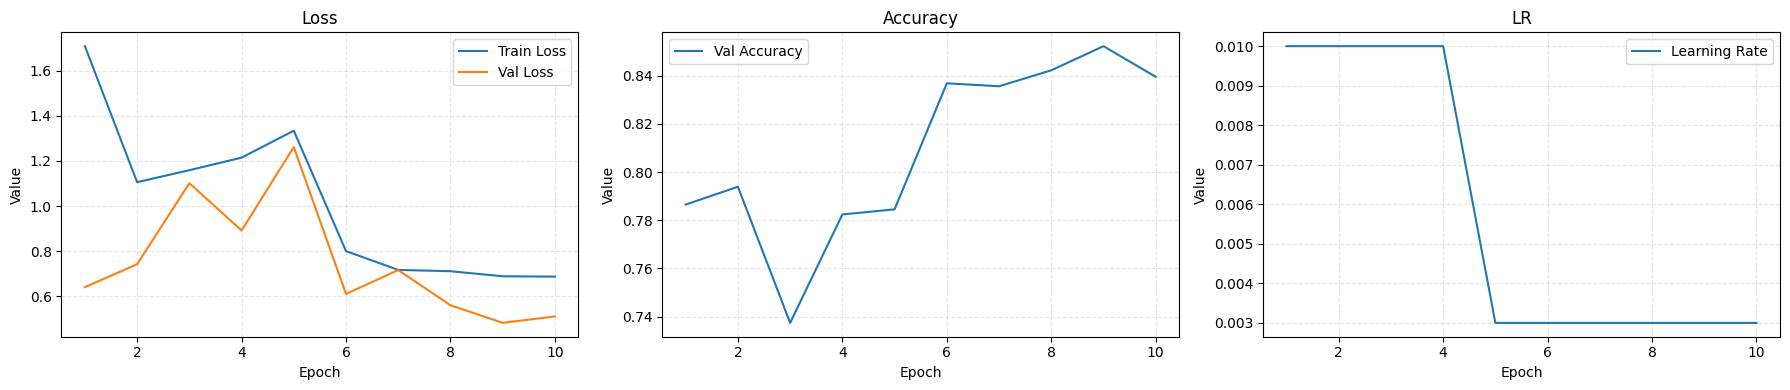

FINAL TEST ACCURACY: 83.95705512321263%


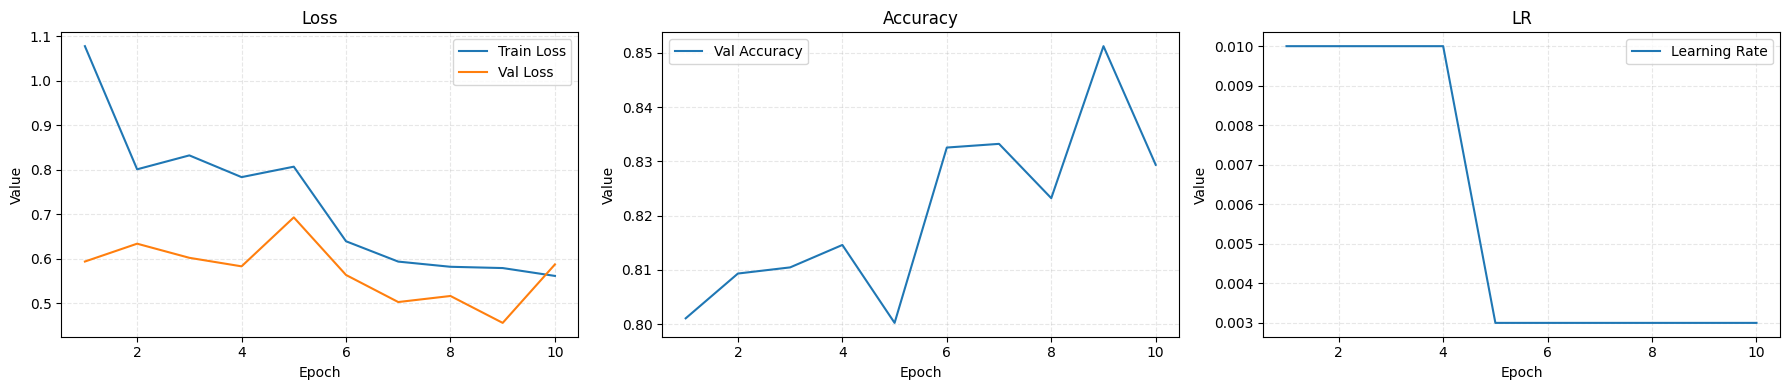

FINAL TEST ACCURACY: 82.93745362045414%


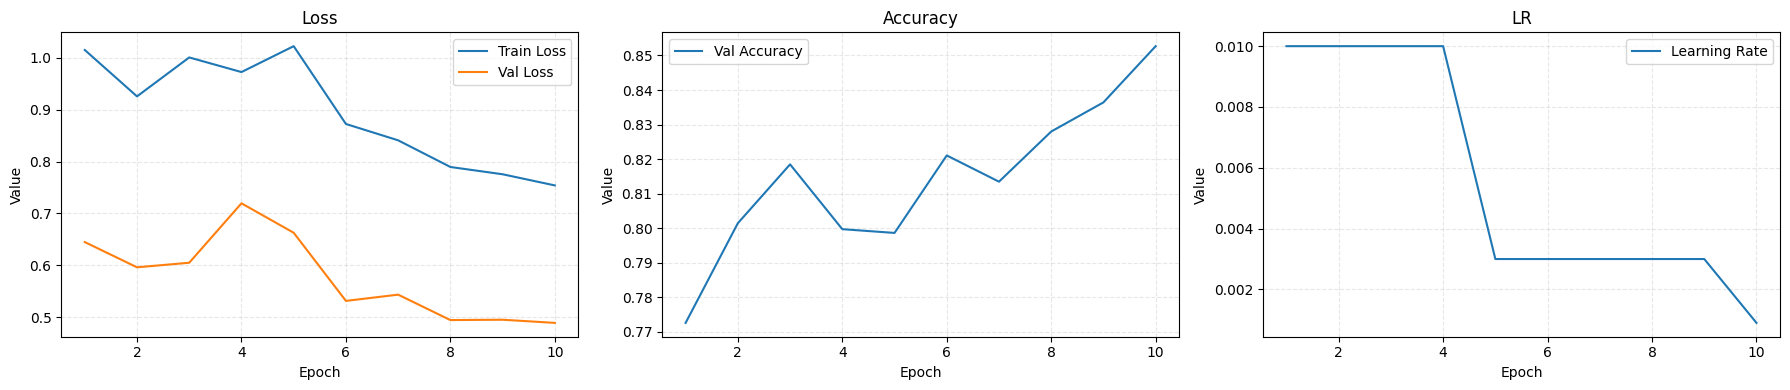

FINAL TEST ACCURACY: 85.2692518910429%


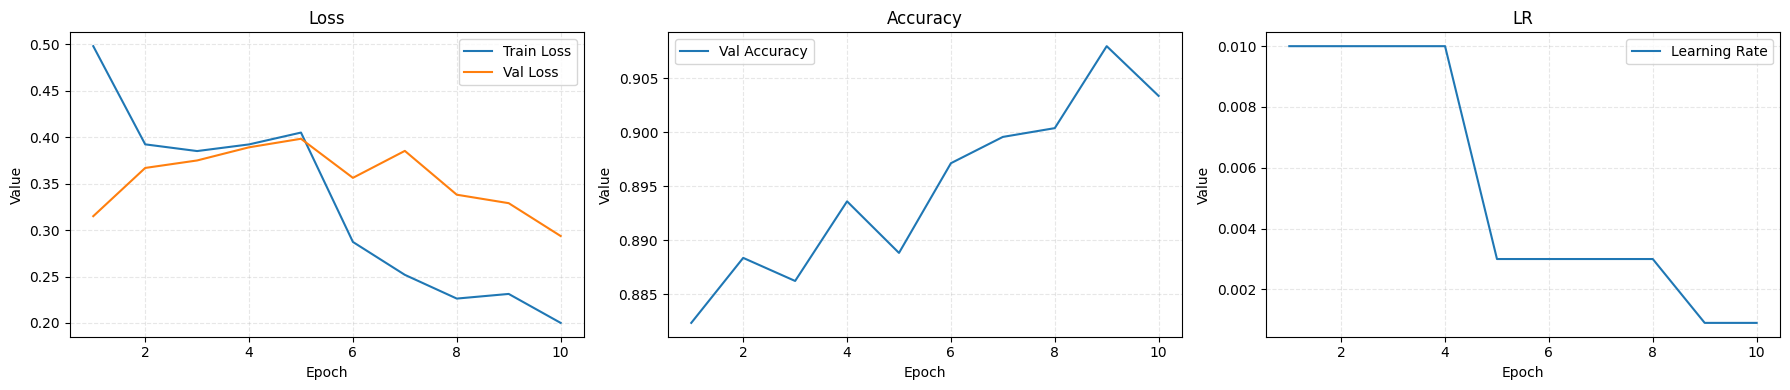

FINAL TEST ACCURACY: 90.33745353409205%


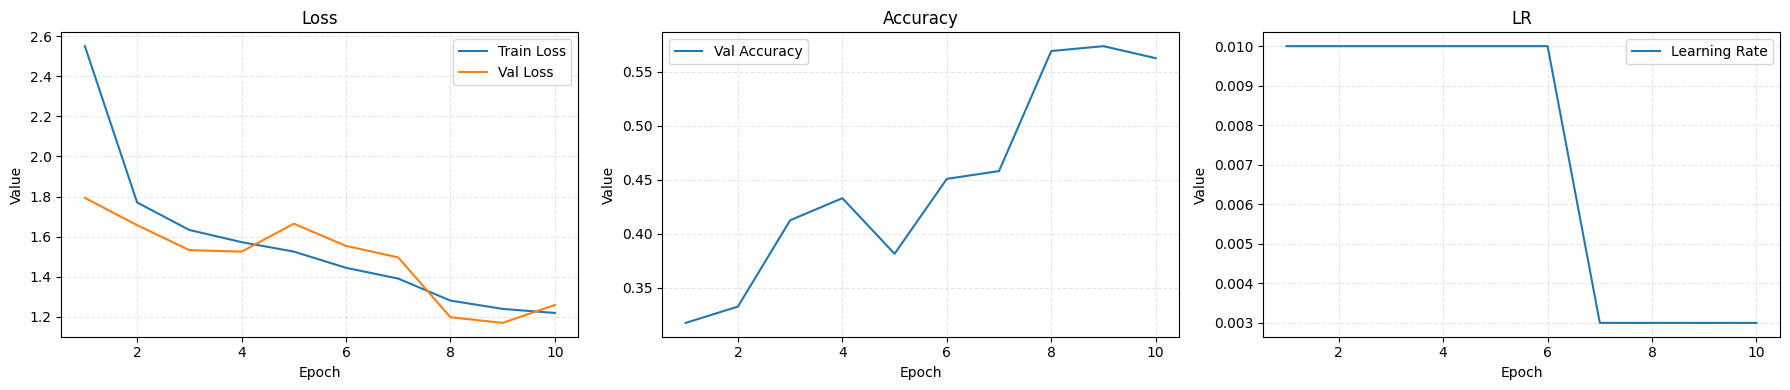

FINAL TEST ACCURACY: 56.26011779610115%


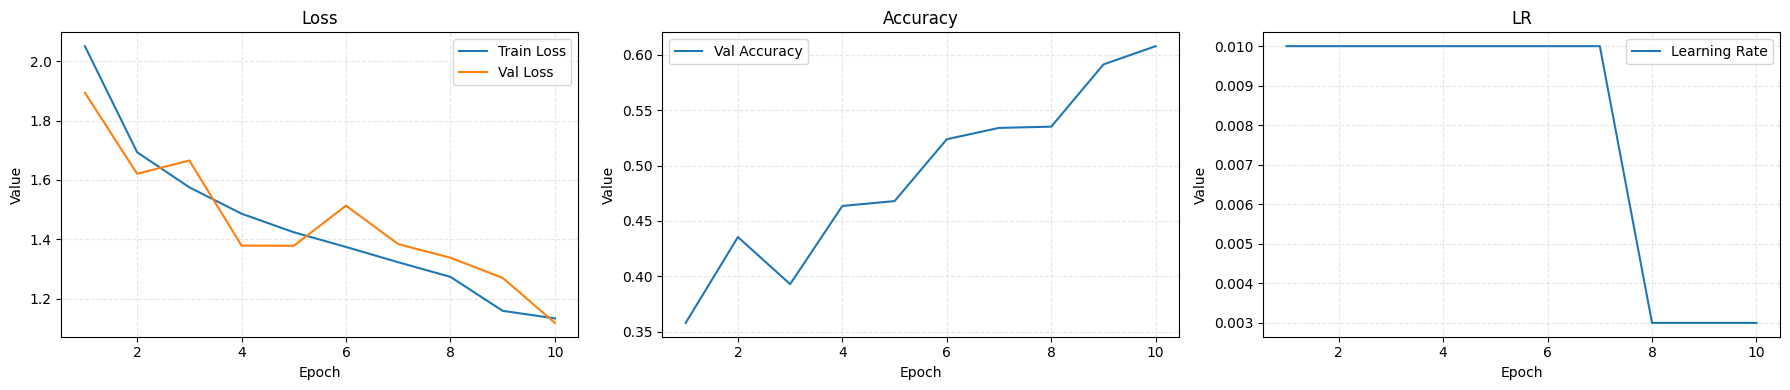

FINAL TEST ACCURACY: 60.787522203556236%


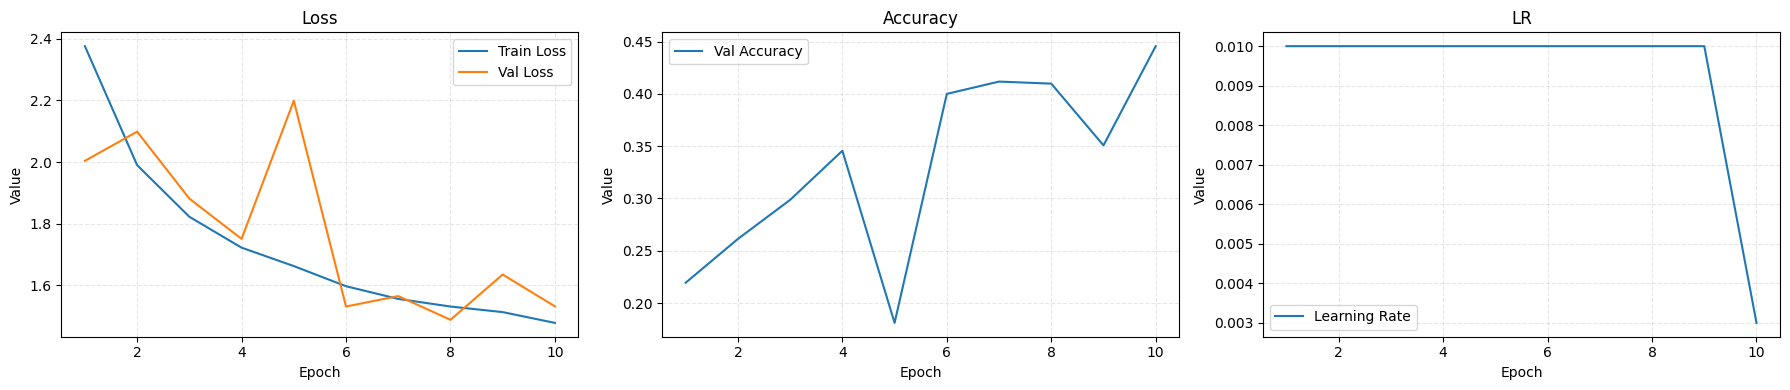

FINAL TEST ACCURACY: 44.55997297428475%


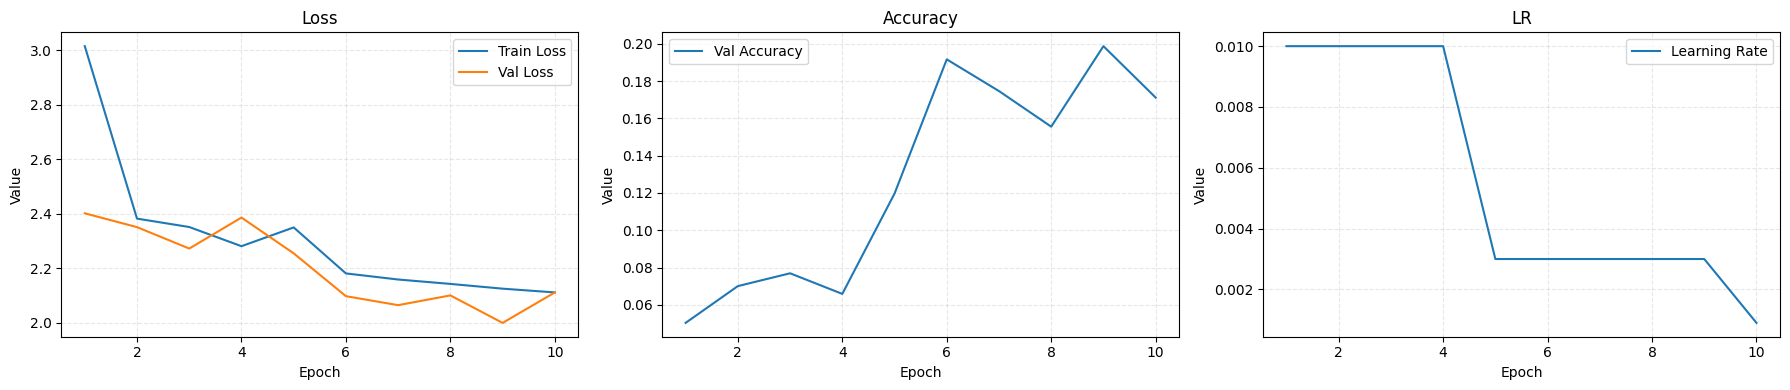

FINAL TEST ACCURACY: 17.115017480128984%


In [25]:
import matplotlib.pyplot as plt
for metrics in finals:
    train_loss = metrics[0]
    val_loss   = metrics[1]
    val_acc    = metrics[2]
    lr         = metrics[3]

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(18, 4))   

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Loss")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("Accuracy")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, lr, label="Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.title("LR")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"FINAL TEST ACCURACY: {val_acc[-1] * 100}%")

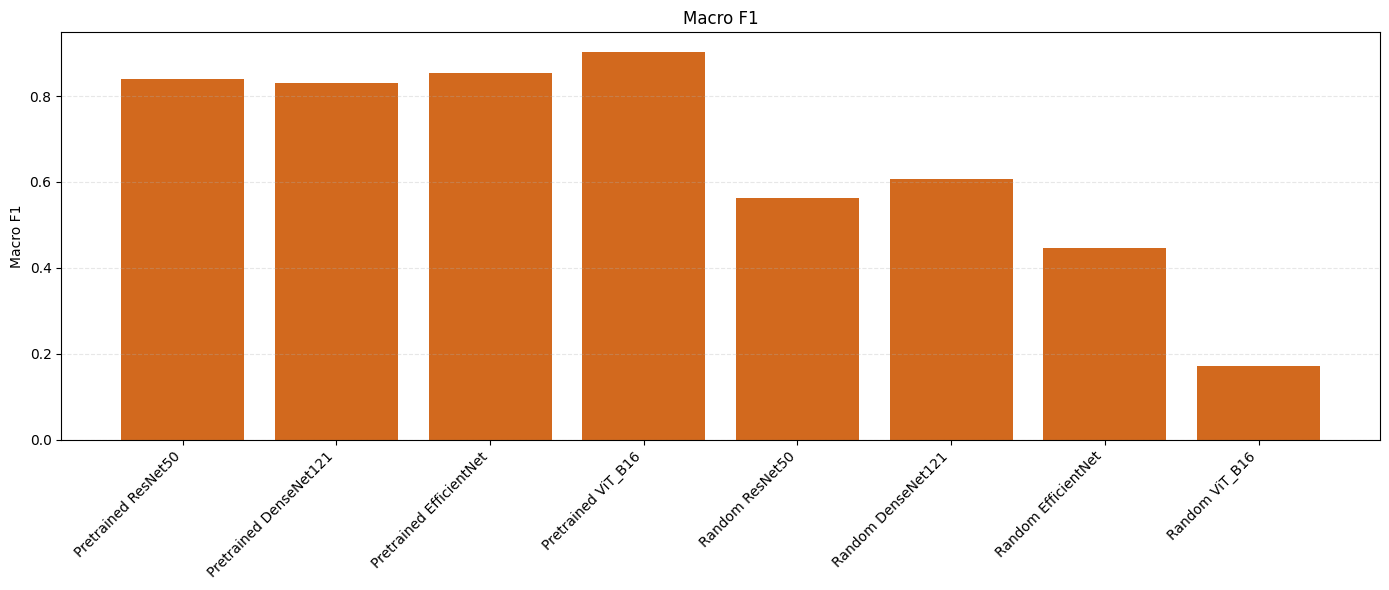

In [42]:
import matplotlib.pyplot as plt
import numpy as np

model_names = []
final_f1 = []

for (name, _), metrics in zip(models, finals):
    val_f1 = metrics[2]          
    f1_last = val_f1[-1]         
    model_names.append(name)
    final_f1.append(f1_last)

plt.figure(figsize=(14, 6))

x = np.arange(len(model_names))
plt.bar(x, final_f1, color="chocolate")

plt.xticks(x, model_names, rotation=45, ha="right")
plt.ylabel("Macro F1")
plt.title("Macro F1")

plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
'''
model = ConvCifar10(num_classes=10)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.to(device)
model.eval()   

'''

'\nmodel = ConvCifar10(num_classes=10)\nmodel.load_state_dict(torch.load("model.pth", map_location=device))\nmodel.to(device)\nmodel.eval()   \n\n'

In [33]:
print(len(models))
model = models[3][1]

8


<Axes: >

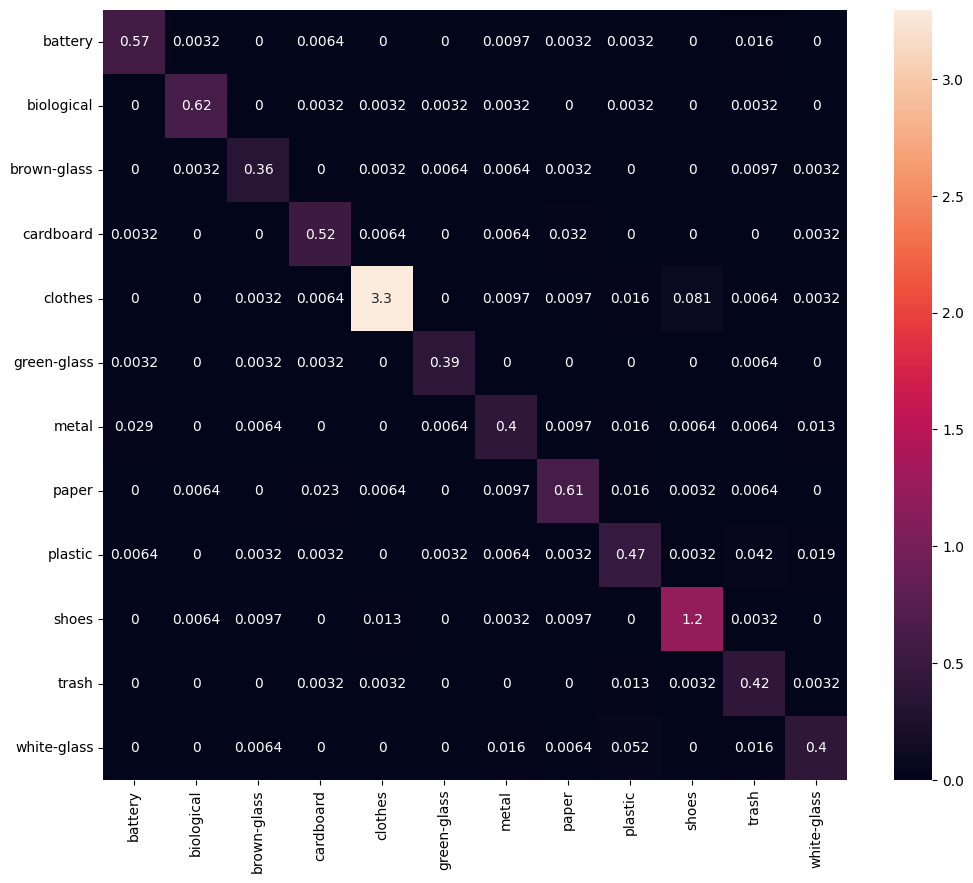

In [34]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np 

class_names = base_dataset.classes

y_pred = []
y_true = []
model.to(device)
model.eval()

with torch.inference_mode():
  for X, y in testloader:
    X , y = X.to(device) , y.to(device)
    pred_logits = model(X)
    pred = pred_logits.argmax(dim=1).cpu().numpy()
    y_pred.extend(pred)
    true = y.cpu().numpy()
    y_true.extend(true)

cf_matrix = confusion_matrix(y_true,y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = class_names, columns = class_names)
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True)

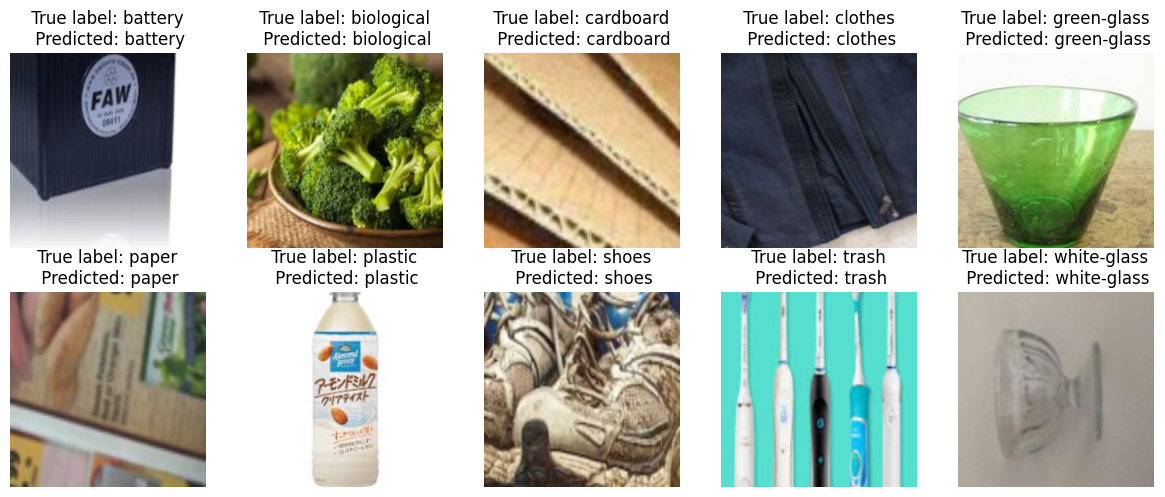

In [36]:
model.to('cpu')
model.eval()


def show_one_per_class(testloader, class_names=None):
    found = {}
    
    for images, labels in testloader:
        for img, lab in zip(images, labels):
            lab = lab.item()
            if lab not in found:
                found[lab] = img
            if len(found) == 10:     
                break
        if len(found) == 10:
            break

    plt.figure(figsize=(12, 5))
    for idx, (lab, img) in enumerate(sorted(found.items())):
        plt.subplot(2, 5, idx+1)
        pred=model(img.unsqueeze(0)).argmax(dim=1)
        img = (img * torch.tensor(std).view(3,1,1) + torch.tensor(mean).view(3,1,1)).clamp(0,1)
        plt.imshow(img.permute(1, 2, 0))
        if class_names:
            title =f" True label: {class_names[lab]} \n Predicted: {class_names[pred]}"
            if class_names[lab] == class_names[pred]:
                plt.title(title)
            else:
                plt.title(title, color = "red")
                
                
        else:
            plt.title(f"class {lab}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


#testset.transform = T.ToTensor()
#testloader = DataLoader(testset, batch_size=512, shuffle = True)
testset  = Subset(test_dataset_full,  test_idx)
testloader = DataLoader(testset, batch_size=512)

class_names = base_dataset.classes

show_one_per_class(testloader, class_names)

